In [1]:
import pandas as pd
# Specify the path to your Feather file
feather_file_path = '/home/bkcs/Desktop/Project-IL--master/CustomerData/Capture_train_256.feather'
df = pd.read_feather(feather_file_path)
df

,flow_id,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,Label
0,1,3,235,175,86,243,39,68,13,24,...,12,250,139,16,32,196,213,83,16,3
1,1,3,235,175,186,42,73,232,76,81,...,143,168,113,80,33,221,3,251,234,3
2,1,3,235,175,197,6,200,121,4,220,...,162,209,217,131,208,68,82,83,69,3
3,1,3,235,175,68,129,53,250,187,126,...,36,143,177,91,247,226,67,221,72,3
4,1,3,235,175,119,124,211,111,238,94,...,108,46,185,117,93,124,215,137,149,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329655,74621,23,3,3,0,53,230,228,114,210,...,0,0,0,0,0,0,0,0,0,4
329656,74621,23,3,3,1,149,142,46,117,220,...,158,57,205,202,253,84,33,86,210,4
329657,74621,23,3,3,0,240,254,109,104,212,...,3,5,115,211,79,238,81,11,121,4
329658,74621,23,3,3,5,115,199,170,142,121,...,104,204,153,222,234,38,133,158,97,4


In [2]:
df_filtered = df[df['Label'] != 12]
df_sorted = df_filtered.sort_values(by='Label')

NUM_FEATURE = 256

def data_processing(df, NUM_FEATURES):
   y_train = df['Label']
   flow_id = df['flow_id']

   df = df/255

   X_train = df.drop(['Label', 'flow_id'], axis=1)
   X_train = X_train.to_numpy() / 255
#    NUM_FEATURES = X_train.shape[1]
  
   # nhom 20packet thanh 1 flow
   X_train = X_train.reshape(-1,20, NUM_FEATURES)

   y_train = y_train.to_numpy()

   # lay nhan cuoi cung
   y_train = y_train.reshape(-1,20)[:,-1] #em chao anhb
   return X_train, y_train

X, y = data_processing(df_sorted, NUM_FEATURE)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train.shape

(11961, 20, 256)

In [5]:
unique_elements = set(y_train)

print(unique_elements)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


In [6]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torch.optim as optim 
import torchvision.datasets as dsets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

DEVICE = torch.device('cuda:0')

# if not os.path.isdir('./Project-dir'):
#   !git clone https://github.com/armando-larocca/Project-IL-

# if not os.path.isdir('content/cifar100.py'):
#   !mv '/content/Project-IL-/cifar100.py' '/content'  
#   !mv '/content/Project-IL-/utils.py' '/content'  

# if not os.path.isdir('content/cifarResnet.py'):
#   !mv '/content/Project-IL-/cifarResnet.py' '/content'

from cifarResnet import resnet32
from cifar100 import *
from SimpleCNN import *
#from resnet import resnet18

# Example data (replace this with your actual data)
train_data_list = {'x': X_train, 'y': y_train}
test_data_list = {'x': X_test, 'y': y_test}

# Instantiate the model, loss function, and optimizer
input_size = len(y_train)
hidden_size = 64
output_size = len(set(y_train))  # Assuming labels are 0-indexed
# Hyper Parameters
num_epochs = 10
batch_size = 10
learning_rate = 3e-4
total_classes = len(set(y_train))
num_classes = 3

In [7]:
class ConvNet(nn.Module):
    def __init__(self, n_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(20, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (256 // 4), 256)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, n_classes, bias=True)

        self.n_classes = n_classes
        self.n_known = 0

        self.p = self.parameters()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    
    def increment_classes(self, n):
      in_features = self.fc.in_features
      out_features = self.fc.out_features
      weight = self.fc.weight.data
      bias = self.fc.bias.data

      self.fc = nn.Linear(in_features, out_features+n, bias=True)
      self.fc.weight.data[:out_features] = weight
      self.fc.bias.data[:out_features] = bias
      self.n_classes += n    

**LwF**

In [8]:
def one_hot(labels,n_cls):
  hot = torch.zeros(len(labels), n_cls)
  hot[range(hot.shape[0]), labels]=1
  
  return hot

**Dataset preparation**

In [9]:
import random
from CustomDataset import *


transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),std=(0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),std=(0.2675, 0.2565, 0.2761)),
])


# shf = []
# for x in range(0,6):
#   shf.append(x)

# random.shuffle(shf)
train_dataset = CustomDataset(train_data_list)
test_dataset = CustomDataset(test_data_list)

# train_dataset._shuffle_(shf)
# test_dataset._shuffle_(shf)

incr_train = train_dataset.__incremental_train_indexes__(1)
incr_val = test_dataset.__incremental_val_indexes__(0)


# Get the list of unique labels
all_labels = list(set(train_dataset.targets))

# Shuffle the labels randomly (you may want to use a fixed seed for reproducibility)
# random.shuffle(all_labels)

# Split the labels into 4 subsets, each with 3 labels
num_subsets = 4
labels_per_subset = 3

subset_indices = [all_labels[i:i+labels_per_subset] for i in range(0, len(all_labels), labels_per_subset)]

# Create subsets using the indices of labels
decine_train = [Subset(train_dataset, [i for i in range(len(train_dataset)) if train_dataset.targets[i] in subset]) for subset in subset_indices]
decine_val = [Subset(test_dataset, [i for i in range(len(test_dataset)) if test_dataset.targets[i] in subset]) for subset in subset_indices]

# decine_train = []
# decine_val = []

# for i in range(0,3):
#   val_dataset = Subset(test_dataset, incr_val[i])
#   training_dataset = Subset(train_dataset, incr_train[i])
#   decine_train.append(training_dataset)
#   decine_val.append(val_dataset) 



# train_dataset = Cifar100(".\Data", train=\True, transform=transform)
# test_dataset = Cifar100(".\Data", train=False, transform=transform_test)

# train_dataset._shuffle_(shf)
# test_dataset._shuffle_(shf)

# incr_train = train_dataset.__incremental_train_indexes__(1)
# incr_val = test_dataset.__incremental_val_indexes__(0)

# decine_train = []
# decine_val = []

# for i in range(0,10):
#   val_dataset = Subset(test_dataset, incr_val[i])
#   training_dataset = Subset(train_dataset, incr_train[i])
#   decine_train.append(training_dataset)
#   decine_val.append(val_dataset) 

In [10]:
# train_loader = torch.utils.data.DataLoader(decine_train[int(0)],batch_size=batch_size,shuffle=True)
# net = ConvNet()
# net.cuda()
# criterion = nn.CrossEntropyLoss()
# # q = torch.zeros(50000, net.n_classes).cuda()
# for  indices, images, labels in train_loader:
#     images = Variable(images).cuda()

#     indices = indices.cuda()
#     old_out = net.forward(images.cuda())
#     print(old_out.data)

    # images = Variable(images).cuda()
    # indices = indices.cuda()
    # old_out = net.forward(images.cuda())
    # # one_hot_batch = one_hot(labels,net.n_classes)
    # # print(images.shape)
    # print(old_out.cuda().shape)
    # print(labels.cuda().shape)

    # criterion(old_out.cuda(), labels.cuda())
    # one_hot_batch = one_hot(labels,net.n_classes)
    # print(one_hot_batch)
    
# q = Variable(q).cuda()

**Main**

In [11]:

net = ConvNet(3)

best_acc = []
tot_matrix = []
tot_labe = []

for s in range(0,3):

  net.cuda()

  train_loader = torch.utils.data.DataLoader(decine_train[int(s)], batch_size=batch_size,shuffle=True)
  test_loader = torch.utils.data.DataLoader(decine_val[int(s)], batch_size=batch_size,shuffle=True)

  print(len(train_loader))
  print(len(test_loader))

  #### OLD OUTPUT ### 
  q = torch.zeros(len(X_train), net.n_classes).cuda()
  for  indices, images, labels in train_loader:
    images = Variable(images).cuda()
    indices = indices.cuda()
    old_out = net.forward(images.cuda())
    q[indices] = old_out.data
    
  q = Variable(q).cuda()
  
  if(s!=0):
    net.increment_classes(3)
    print("New n_class:", net.n_classes)

  net.cuda()
  net.train(True)
  p = net.parameters()
  optimizer = optim.SGD(p, lr=2.0,weight_decay=0.00001,momentum=0.9) 
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [49,63], gamma=0.2)
    
  matrix = []
  labe = []    
  b_ac = 0

  #### TRAIN ### 
  for epoch in range(0,1):

    running_corrects = 0 
    total = 0

    for indices, images, labels in train_loader:
      images = Variable(images).cuda()
      labels = Variable(labels).cuda()
      indices = indices.cuda()
      optimizer.zero_grad()

      g = net.forward(images.cuda())

      _, preds = torch.max(g, 1)
      running_corrects += torch.sum(preds == labels.data).data.item()
      total += labels.size(0)

      ##### LOSS #######
      q_i = q[indices]
      one_hot_batch = one_hot(labels,net.n_classes)
      sigmoid = nn.Sigmoid()
      criterio=nn.BCEWithLogitsLoss() 
      criterio1= nn.CrossEntropyLoss()
      criterio 
      q_i.cuda()
      g.cuda()

      if(net.n_classes==3):
        loss = criterio(g, one_hot_batch.cuda())  
      else: 
        x1 = q_i[:,:net.n_classes-3]
        x2 = one_hot_batch[: ,net.n_classes-3 :net.n_classes]            
        target = torch.cat( (sigmoid(x1), x2.cuda()) , 1)
        loss = criterio(g, target)
        
      ####################

      loss.backward()
      optimizer.step()

    accuracy = running_corrects / float(total)       
    scheduler.step()
    print ('Epoch [%d/%d], Loss: %.4f, Acc: %.2f' %(epoch+1, num_epochs, loss.data, accuracy)) 
    
    #### TEST ####
    m=[]
    l=[]
    net.train(False)

    total = 0.0
    running_corrects = 0
    for indices, images, labels in test_loader:
        images = Variable(images).cuda()
        out = net.forward(images)
        _, preds = torch.max(out, 1)
        running_corrects += torch.sum(preds.cpu() == labels.data).data.item()
        total += labels.size(0)

        m.extend(preds) 
        l.extend(labels)

    matrix.append(m)
    labe.append(l)     

    accuracy = float(running_corrects / float(total))
    print('Test Accuracy',accuracy)

    if(b_ac < accuracy):
      b_ac = accuracy 

  tot_matrix.append(matrix)
  tot_labe.append(labe)
  best_acc.append(b_ac)       

248
64
Epoch [1/10], Loss: nan, Acc: 0.36
Test Accuracy 0.3665086887835703
222
56
New n_class: 6
Epoch [1/10], Loss: nan, Acc: 0.00
Test Accuracy 0.0
575
144
New n_class: 9
Epoch [1/10], Loss: nan, Acc: 0.00
Test Accuracy 0.0


**Confusion matrix**

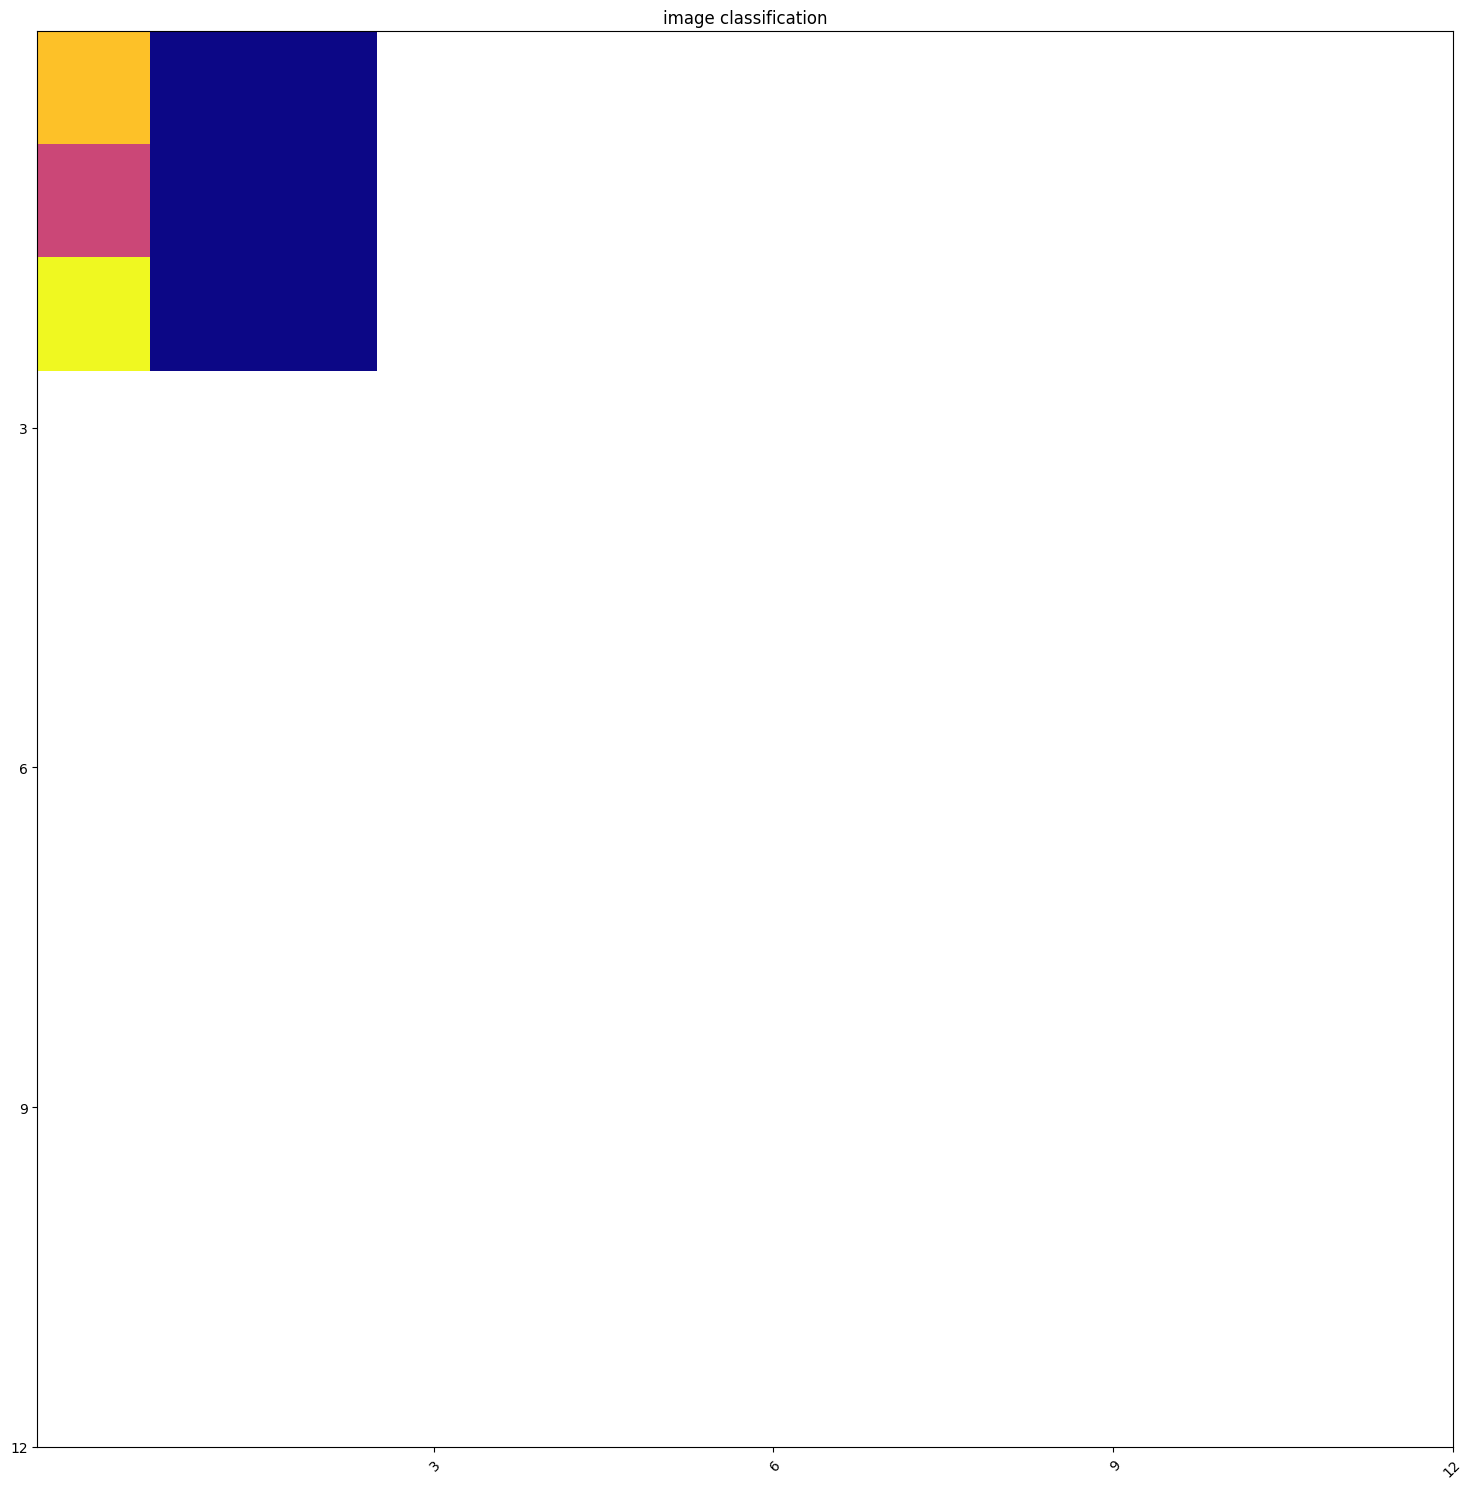

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt

tacche = [3,6,9,12]

x =  tot_matrix[0][0]
l = tot_labe[0][0]

l =[int(i) for i in l]
x =[int(i) for i in x]

cf = confusion_matrix(list(l),list(x))

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cf,cmap = 'plasma')

ax.set_yticks(tacche)
ax.set_xticks(tacche)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.set_title("image classification")
fig.tight_layout()
plt.show()

**Accuracy plot**

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

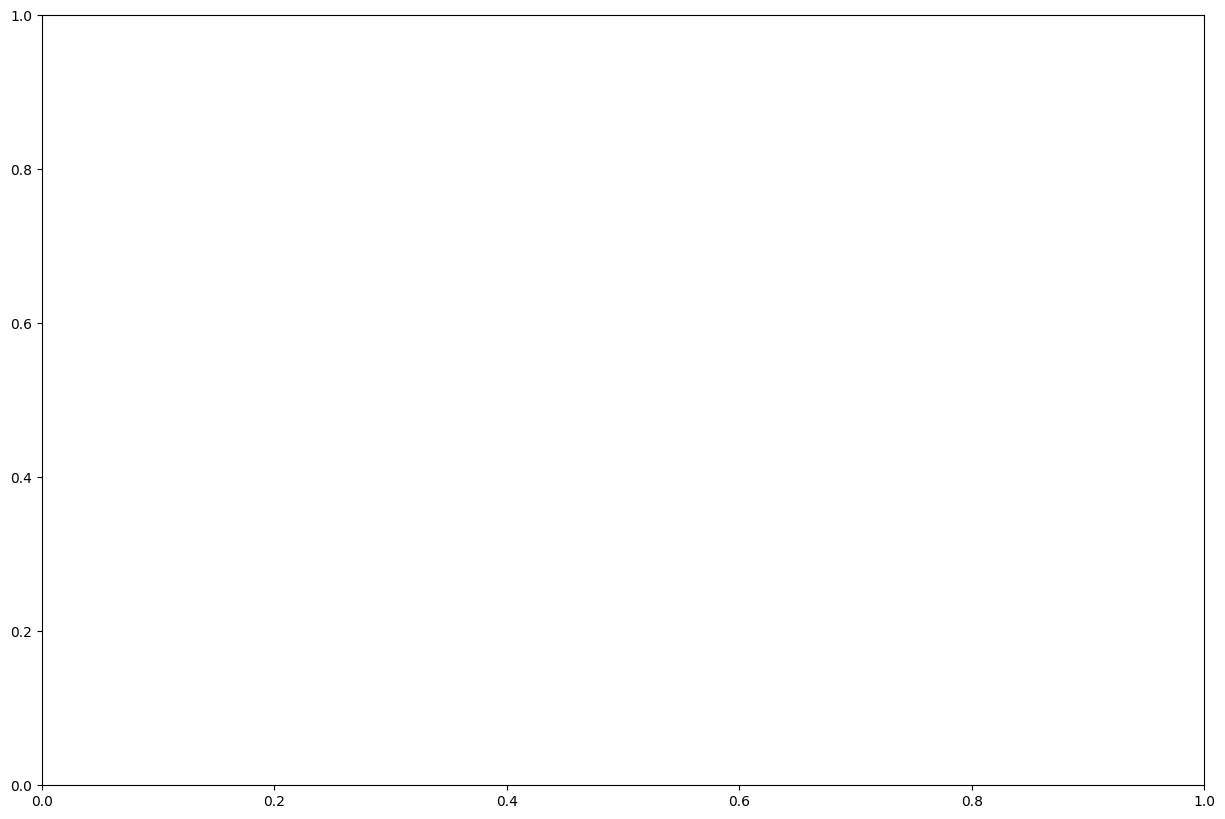

In [13]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot([3,6,9,12],best_acc,'k-o')
plt.xlim(10,100)
plt.ylim(0,1)
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.show()

print(best_acc)